#Imports

In [1]:
import os
import io
import torch
import sklearn
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Flatten, Dense, Embedding, concatenate,LSTM
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from google.colab import drive
drive.mount("/content/drive")

#! cp "/content/drive/My Drive/dataML2023/glove.6B.50d.txt" .

! cp "/content/drive/My Drive/dataML2023/embeddings-xs-model.vec" .
! cp "/content/drive/My Drive/dataML2023/dataset123.csv" .
! cp -r "/content/drive/My Drive/dataML2023/img123" .

#ONLY WHEN YOU HAVE TO PREDICT USING EXISTING MODEL
#! cp -r "/content/drive/My Drive/ORT/ML Prod/Obligatorio/Modelo/model.h5" .

#path= "Users/GP147352/Obligatorio/glove.6B.50d.txt"
file = "s101006-2l-13-54ce75b2-6d98-4e88-bad4-1a1e94b2b4cb_fdf66140-1db7-4dc4-8c6a-f8f58ec87151.jpg_v=1686155027"
path="glove.6B.50d.txt"
path="embeddings-xs-model.vec"

Mounted at /content/drive


#Image Utilities

In [2]:
def getImagesInFolder():
  folder_path = 'img123'
  elements = os.listdir(folder_path)
  count = len(elements)

  print("Number of elements in the folder:", count)

In [3]:
def showImage(img_path):
  #img_path = "img/s101006-2l-13-54ce75b2-6d98-4e88-bad4-1a1e94b2b4cb_fdf66140-1db7-4dc4-8c6a-f8f58ec87151.jpg_v=1686155027"

  image = Image.open(img_path)

  image.show()

In [4]:
def getImageFileName(url):

  delimiterString = "/"

  index = url.rfind(delimiterString)+ 1

  imageFileName = url[index:]

  imageFileName = imageFileName.replace('?', '_')

  return imageFileName

In [5]:
def imageToBytes(filename):
  try:
    with open(filename, 'rb') as file:
        byte_stream = file.read()
    return byte_stream
  except FileNotFoundError:
    print(f"File '{filename}' not found.")
    return None

In [6]:
def converToRGB(image):
    if image.mode == 'RGBA':
        # Create a new RGB image with a white background
        rgb_image = Image.new('RGB', image.size, (255, 255, 255))
        # Composite the RGBA image onto the RGB image
        rgb_image.paste(image, mask=image.split()[3])
        return rgb_image
    elif image.mode == 'RGB':
        # If the image is already in RGB format, return it as it is
        return image
    else:
        # For other image modes, convert to RGB
        return image.convert('RGB')

In [7]:
def preProcessPredictImage(image):
    image = converToRGB(image)
    image = image.resize((299, 299))
    image = np.array(image)
    #Convert pixel values to the range of [-1, 1] + Normalize the image by subtracting the mean RGB values of the ImageNet dataset.
    image = tf.keras.applications.xception.preprocess_input(image)
    image = np.expand_dims(image, axis=0)
    return image

In [8]:
def preProcessImage(image_path):
    image = Image.open("img123/"+image_path)
    image = converToRGB(image)
    #print("img123/"+image_path)
    image = image.resize((299, 299))
    image = np.array(image)
    image = tf.keras.applications.xception.preprocess_input(image)
    image = np.expand_dims(image, axis=0)
    return image

In [9]:
train_images = []
def addImagesToDataSet():
  for index, row in df.iterrows():
    image_url = row['images']
    #print(image_url)
    image_fileName = getImageFileName(image_url)
    #print(image_fileName)
    image = preProcessImage(image_fileName)
    train_images.append(image)
    #print(type(image))
    #df.at[index, 'imageObj'] = image

In [10]:
def addImagesToDataSet(df):
  images = []
  for index, row in df.iterrows():
    image_url = row['images']
    image_fileName = getImageFileName(image_url)
    image = preProcessImage(image_fileName)
    images.append(image)

  return images

In [35]:
def dataAugmentation(trainImages):
  #https://fairyonice.github.io/Learn-about-ImageDataGenerator.html
  # Define the data augmentation parameters
  datagen = ImageDataGenerator(
    rotation_range=20,#Degree range for random rotations.
    shear_range=0.2,#Shear angle in degrees.
    zoom_range=0.2,#Range for random zoom
    horizontal_flip=True,#Randomly flip inputs horizontally.
    )
  x= np.stack(trainImages)
  # Reshape the input to match the expected shape for data augmentation
  x = x.reshape((-1,) + x.shape[2:])
  # Generate augmented images
  augmented_images = []
  counter = 0
  for img in x:
    img = np.expand_dims(img, axis=0)  # Add an extra dimension to match batch size of 1
    augmented_image = next(datagen.flow(img, batch_size=1))
    #print(len(augmented_image))
    augmented_image = np.expand_dims(augmented_image, axis=0)
    augmented_images.append(augmented_image[0])
    counter += 1
    if counter >= len(x):
        break
  return augmented_images

In [12]:
def showImages(images):
  fig, axes = plt.subplots(nrows=len(images), ncols=1, figsize=(100, 100))
  for i, img in enumerate(images):
      if img.ndim == 2:
        axes[i].imshow(img, cmap='gray')
      elif img.ndim == 3:
        axes[i].imshow(img)
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()

# Preprocesamiento Texto

In [13]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')
stemmer = SnowballStemmer('spanish')

def remove_special_characters(text):
  pattern = r'[^a-zA-Z0-9\s]'
  text = re.sub(pattern,'',text)
  return text

def low_level_preproc(text):
  text = remove_special_characters(text)
  text = text.lower()
  return text
# Remove stopwords for spanish language: https://github.com/Alir3z4/stop-words/blob/master/spanish.txt
all_stopwords = set(stopwords.words("spanish"))

def remove_stop_words(full_text_line):
  tokens = full_text_line.split()
  tokens = [tok for tok in tokens if tok not in all_stopwords]

  return " ".join(tokens)

#Lemmatization is the process of reducing words to their base or root form
#"The cats were playing with the mice"
#The cat were playing with the mouse
def lemmatize(text):
  wnl= WordNetLemmatizer()
  lemas = [wnl.lemmatize(word) for word in text.split()]

  return " ".join(lemas)

#Stemming: reduce words to their base or root form
#words = ['correr', 'corriendo', 'corre', 'corrió']
#output= ['corr', 'corr', 'corr', 'corr']
def stem(text):
  stemmed_words = [stemmer.stem(word) for word in text.split()]
  return " ".join(stemmed_words)


def high_level_preproc(text):
  text = remove_stop_words(text)
  return stem(text)

def remove_empty_words(questions_data):
  df = questions_data
  originalLen = len(df)
  indexes = []
  for index ,row in df.iterrows():
    text = row['question_text']
    if (text==""):
      indexes.append(index)

  df = df.drop(indexes);
  finalLen = len(df)
  print(f"Len Original: {originalLen}, Registros Eliminados: {originalLen-finalLen}")
  return df

def remove_duplicated(serie):
  return serie.drop_duplicates()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Load DataSet

In [14]:
# Read the uploaded file
df = pd.read_csv('dataset123.csv')
df['imageObj'] = None

In [ ]:
#df = df.drop(to_delete)

##Process Text

In [15]:
# Concatenate title and description
title_desc =  df.iloc[:, 0] + df.iloc[:, 1]
# Print the updated DataFrame
print(title_desc)

0     Gold Standard 100% Whey Protein (2 Lb) - Origi...
1     Enjuague Bucal Tea Tree (500 ml)Nuestras formu...
2     MÃ¡scara Jelly Mask Hydrating Vitamina E (1 un...
3     VITAMINA K2Vitamina K2 es un suplemento alimen...
4     Hand Grip + ContadorHAND GRIP AJUSTABLE FITNES...
                            ...                        
65    Lentes de Sol Polaroid 8411A 9CA 63/16Descripc...
66    Armazones Unofficial UNOM0063 BB00 52/19CoÌdi...
67    Lentes de Sol Ray Ban 2140 902/57 50/22CoÌdig...
68    Lentes de Sol Unofficial  UNSM0014 HHE0 57/14D...
69    Lentes de Sol Unofficial Polarizado UNSU0083PH...
Length: 70, dtype: object


In [16]:
#Procesamiento de Bajo Nivel
title_desc = title_desc.apply(low_level_preproc)
print(title_desc)

0     gold standard 100 whey protein 2 lb  original1...
1     enjuague bucal tea tree 500 mlnuestras formula...
2     mscara jelly mask hydrating vitamina e 1 unmas...
3     vitamina k2vitamina k2 es un suplemento alimen...
4     hand grip  contadorhand grip ajustable fitness...
                            ...                        
65    lentes de sol polaroid 8411a 9ca 6316descripci...
66    armazones unofficial unom0063 bb00 5219codigo ...
67    lentes de sol ray ban 2140 90257 5022codigo de...
68    lentes de sol unofficial  unsm0014 hhe0 5714de...
69    lentes de sol unofficial polarizado unsu0083ph...
Length: 70, dtype: object


In [17]:
#Procesamiento de Alto Nivel
title_desc =title_desc.apply(high_level_preproc)
print(title_desc)

0     gold standard 100 whey protein 2 lb original10...
1     enjuag bucal tea tre 500 mlnuestr formul enjua...
2     mscar jelly mask hydrating vitamin 1 unmascari...
3     vitamin k2vitamin k2 suplement alimentari perm...
4     hand grip contadorhand grip ajust fitness blu fit
                            ...                        
65    lent sol polar 8411a 9ca 6316descripciongener ...
66    armazon unofficial unom0063 bb00 5219codig pro...
67    lent sol ray ban 2140 90257 5022codig product ...
68    lent sol unofficial unsm0014 hhe0 5714descripc...
69    lent sol unofficial polariz unsu0083phhe0 5422...
Length: 70, dtype: object


In [18]:
#LOAD
embedding_path="embeddings-xs-model.vec"
embeddings_index = {}
with open(embedding_path) as f:
    #print(f)
    for line in f:
        #print(line)
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1313424 word vectors.


In [19]:
# Create an embedding matrix
from tensorflow.keras.preprocessing.text import Tokenizer
text_list = title_desc.tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_list)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
vocab_size

1044

In [21]:
embedding_dim = 10
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_text_sequences = tokenizer.texts_to_sequences(text_list)
X_text_padded = pad_sequences(X_text_sequences, maxlen=20)

In [23]:
df['textSequence'] = None
df['textSequence'] = pd.Series(X_text_padded.tolist())

In [ ]:
df['textSequence'].values[1]

#SPLIT TRAIN

In [25]:
def split(train):

    # Split train to train and validation datasets
    # Validation for use during learning
    train, val = train_test_split(train, test_size=0.2, random_state=24)

    return(train, val)

#Create Model

In [26]:
text_input = Input(shape=(20,), dtype='int32', name='tag')#20 largo de descripciones o titulo a utilizar
embedding_layer = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix], trainable=False)(text_input)
text_output = LSTM(64)(embedding_layer)

In [27]:
base_model = Xception(weights='imagenet', include_top=False)

image_input = Input(shape=(299, 299, 3))
x = base_model(image_input)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
image_output = Dense(64, activation='relu')(x)

83683744/83683744 [==============================] - 1s 0us/step


In [28]:
concatenated = concatenate([image_output, text_output])
output = Dense(1, activation='sigmoid')(concatenated)
x = Dense(64, activation='relu')(concatenated)
output = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=[image_input, text_input], outputs=output)
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model

In [29]:
train, val = split(df)
print(f"DataSet Original:{len(df)}, Train:{len(train)},Validation:{len(val)}")

DataSet Original:70, Train:56,Validation:14


In [ ]:
train

In [31]:
num_classes = len(df['store'].unique())
print(num_classes)

3


In [36]:
trainImages = addImagesToDataSet(train)
augmentedImages = dataAugmentation(trainImages)
originalAndAugmented = trainImages + augmentedImages

In [39]:
from tensorflow.keras.utils import to_categorical
#X_train_images = train['image_bytes']
X_train_images = np.concatenate(originalAndAugmented, axis=0)

# Duplicate all train values (we asume 1 augmented image per row)
textSequence = train['textSequence']
textSequence = pd.concat([textSequence] * 2, ignore_index=True)
X_train_text = tf.convert_to_tensor(textSequence.tolist())
#X_train_text = tf.convert_to_tensor(train['textSequence'].tolist())
orginalAndDuplicatedStores =  train['store']
orginalAndDuplicatedStores = pd.concat([orginalAndDuplicatedStores] * 2, ignore_index=True)
y_train = to_categorical(orginalAndDuplicatedStores.astype(int).values, num_classes)

#X_test_images = val['image_bytes']
X_test_images = np.concatenate(addImagesToDataSet(val), axis=0)
X_test_text = tf.convert_to_tensor(val['textSequence'].tolist())
y_test = to_categorical(val['store'].astype(int).values, num_classes)

In [40]:
history = model.fit([X_train_images, X_train_text], y_train, epochs=8, validation_data=([X_test_images, X_test_text], y_test))

Epoch 1/8
4/4 [==============================] - 275s 56s/step - loss: 1.7364 - accuracy: 0.3304 - val_loss: 1.0728 - val_accuracy: 0.3571
Epoch 2/8
4/4 [==============================] - 228s 55s/step - loss: 1.0341 - accuracy: 0.5357 - val_loss: 1.0063 - val_accuracy: 0.3571
Epoch 3/8
4/4 [==============================] - 227s 56s/step - loss: 0.8198 - accuracy: 0.6429 - val_loss: 3.2032 - val_accuracy: 0.3571
Epoch 4/8
4/4 [==============================] - 205s 48s/step - loss: 0.6863 - accuracy: 0.7411 - val_loss: 5.8525 - val_accuracy: 0.4286
Epoch 5/8
4/4 [==============================] - 197s 47s/step - loss: 0.5718 - accuracy: 0.9375 - val_loss: 2.2441 - val_accuracy: 0.6429
Epoch 6/8
4/4 [==============================] - 208s 50s/step - loss: 0.4003 - accuracy: 0.9821 - val_loss: 1.6186 - val_accuracy: 0.6429
Epoch 7/8
4/4 [==============================] - 204s 50s/step - loss: 0.2435 - accuracy: 1.0000 - val_loss: 0.8894 - val_accuracy: 0.6429
Epoch 8/8
4/4 [============

#Plot

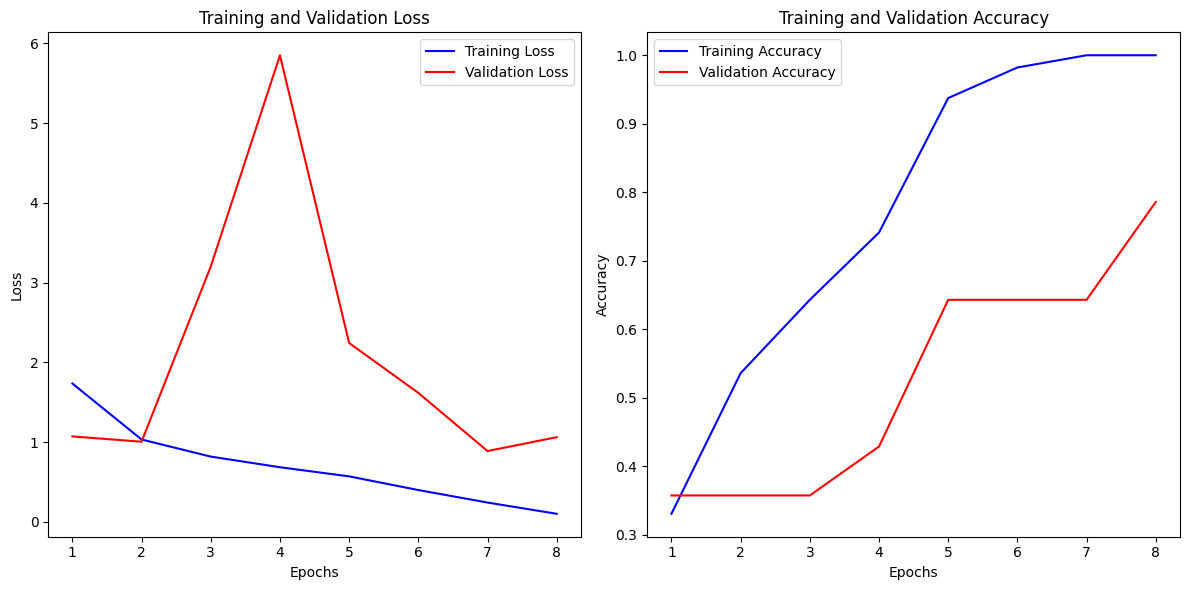

In [41]:
import matplotlib.pyplot as plt

# Access the training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Save Model

In [42]:
model.save('model2.h5')

# Load Saved Model

In [5]:
from keras.models import load_model
model = load_model('model.h5')

#Predict

## Process Text

In [66]:
text_input = "ray ban"
#text_input = ""
#text_input ="exfoliante"
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert the text to a numerical representation using a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text_input])
numerical_text = tokenizer.texts_to_sequences([text_input])[0]
# Pad the numerical text sequence to have a length of 20
padded_text = pad_sequences([numerical_text], maxlen=20)
# Remove the extra dimension
padded_text = tf.squeeze(padded_text, axis=0)


## Process Image

In [67]:
import cv2
import numpy as np
import requests
from tensorflow.keras.preprocessing import image
# Load the image

image_url= "https://cdn.shopify.com/s/files/1/0015/7610/8121/products/805289602057_1050x700.png?v=1664469337"

# Fetch the image from the URL
response = requests.get(image_url, stream=True)
image_data = response.content

# Load the image using PIL
img = Image.open(io.BytesIO(image_data))

# Show the downloaded image
#img.show()

imageResult = preProcessPredictImage(img)


## Get Predictions

In [68]:
predictions = model.predict([imageResult, tf.convert_to_tensor([padded_text])])
print(predictions)

1/1 [==============================] - 0s 401ms/step
[[7.4756123e-38 2.2024572e-30 1.0000000e+00]]


In [71]:
sorted_indices = np.argsort(predictions)[::-1]
print(sorted_indices)

[[0 1 2]]


In [74]:
print(predictions[0])

[7.4756123e-38 2.2024572e-30 1.0000000e+00]


## Plot Results

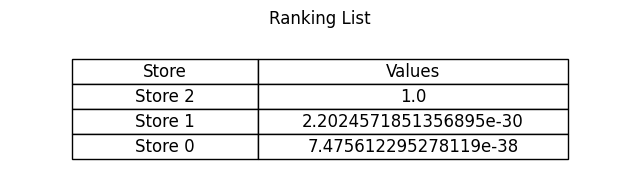

In [88]:
import matplotlib.pyplot as plt

# Generate the corresponding labels for the ranking
labels = ['Store 0', 'Store 1', 'Store 2']

# Create a DataFrame from the items and values
df = pd.DataFrame({'Store': labels, 'Values': predictions[0]})

# Sort the DataFrame by values in descending order
df = df.sort_values(by='Values', ascending=False)

# Reset the index of the DataFrame
df = df.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
table = plt.table(cellText=df.values,
                  colLabels=df.columns,
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.3, 0.5])
table.scale(1, 1.5)  # Adjust the scale of the table
table.set_fontsize(12)


plt.title('Ranking List')
plt.show()